In [1]:
# This code cell imports stuff, etc.

import numpy as np
import matplotlib.pyplot as plt
from time import time as tm
import seaborn as sns

# Import local functions and params
from utils import *
from SpikingNetworkModels import EIFNetworkSimHebb
from SpikingNetworkModels import EIFNetworkSim

#from DefaultParams import *

# Time duration and step size of sim in ms
T=32000
dt=.1
time=np.arange(0,T,dt)
Nt=len(time)
Tburn=1000
Nburn=int(Tburn/dt)

# Number of E and I neurons in network
Ne = 4000
Ni = 1000
Ns=[Ne,Ni]
N = Ne+Ni


# Connection probabilities and weights between
# E and I neurons
p0=0.1
P = p0+np.zeros((2,2))#np.array([[.1,.1],[.1,.1]])
Jm = 0.5*np.array([[25.0,-150.0],[112.5,-250.0]])/np.sqrt(N)

# Synaptic time constants in ms
tau=np.array([8.0,4.0])


# Neuron parameters
NeuronParams = dict()
NeuronParams['Cm']=1.0
NeuronParams['gL']=1/15.0
NeuronParams['EL']=-72.0
NeuronParams['Vth']=0.0
NeuronParams['Vre']=-75.0
NeuronParams['Vlb']=-100.0
NeuronParams['DeltaT']=1.0
NeuronParams['VT']=-55.0


# Mean-field variables
Q=np.array([[Ne,Ni],[Ne,Ni]])/N
Wmf = Jm*P*Q*np.sqrt(N)
Xmf = 0.6*np.array([.04,.02])

# Baseline external input to each neuron
X0 = Xmf*np.sqrt(N)

# Compute balanced rates for E and I neurons.
# This gives a rough approx to the actual rates
# if the network is approximately balanced.
rBal = -np.linalg.inv(Wmf)@Xmf
print('rBal = ',1000*rBal[0],1000*rBal[1],'Hz')

# Stimulus params
StimDim = 10
taustim = 25.0
sigmastim = X0.mean()/15.0


# Params for multi-trial sims
numtrials=20

# Window size for count correlations
winsize=250

# Percent of conn matrix to re-wire
alpha=0.8


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
rBal =  9.882352941176466 22.588235294117638 Hz


In [2]:

import warnings


# Get stimulus weights
Jx=sigmastim*(np.random.randn(N,StimDim)+1.0)
Jx[Ne:,:]=0

# Get random recurrent connectivity matrix
J=GetBlockErdosRenyi(Ns,Jm,P,Ns)

# Create re-wired Like-to-Like connectivity matrix
Pe1=Jx[:Ne,:]@Jx[:Ne,:].T
Pe1=Pe1-Pe1.min()
Pe1=Pe1-Pe1*np.eye(Ne)
Pe1 = Pe1*(alpha*p0/Pe1.mean())
Pe1[Pe1<0]=0
MaskEE=np.random.binomial(1,1.0-alpha,size=(Ne,Ne))
JLikeLike=J.copy()
JLikeLike[:Ne,:Ne]=MaskEE*JLikeLike[:Ne,:Ne]+Jm[0,0]*np.random.binomial(1,Pe1,size=(Ne,Ne))

# External input on top of baseline
X=np.zeros((StimDim,Nt))
for j in range(StimDim):
  X[j,:]=MakeSmoothGaussianProcess(taustim,Nt,dt)


maxns=int(.05*Ne*Nt)+1
Ierecord=[0,1,2]
t0=tm()
RateTime=np.arange(0,T,winsize)
reRand = np.zeros((numtrials,Ne,len(RateTime)))
riRand = np.zeros((numtrials,Ni,len(RateTime)))
reLikeLike = np.zeros((numtrials,Ne,len(RateTime)))
riLikeLike = np.zeros((numtrials,Ni,len(RateTime)))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    for iii in range(numtrials):

        # Run random connectivity sim
        se,si,VeRec = EIFNetworkSim(J,Jx,X,X0,Ne,NeuronParams,tau,Nt,dt,maxns,Ierecord)
        se=se[:,se[0,:]>=0]
        si=si[:,si[0,:]>=0]
        reRand[iii,:,:] = GetSpikeCounts(se,winsize,Ne,T)/winsize
        riRand[iii,:,:] = GetSpikeCounts(si,winsize,Ni,T)/winsize
        print(iii+1,'of',numtrials,'rSimRand =',1000*reRand[iii,:,:].mean(),1000*riRand[iii,:,:].mean(),'Hz. ',tm()-t0,'s')
        
        # Run like-like sims.
        se,si,VeRec = EIFNetworkSim(JLikeLike,Jx,X,X0,Ne,NeuronParams,tau,Nt,dt,maxns,Ierecord)
        se=se[:,se[0,:]>=0]
        si=si[:,si[0,:]>=0]
        reLikeLike[iii,:,:] = GetSpikeCounts(se,winsize,Ne,T)/winsize
        riLikeLike[iii,:,:] = GetSpikeCounts(si,winsize,Ni,T)/winsize
        print(iii+1,'of',numtrials,'rSimLikeLike =',1000*reLikeLike[iii,:,:].mean(),1000*riLikeLike[iii,:,:].mean(),'Hz. ',tm()-t0,'s')

print('Sims complete.')        

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
1 of 20 rSimRand = 8.089390625 15.021812500000003 Hz.  69.69563817977905 s
1 of 20 rSimLikeLike = 8.2860390625 15.334906250000003 Hz.  140.70694303512573 s
2 of 20 rSimRand = 8.0931875 15.025031250000001 Hz.  211.51809787750244 s
2 of 20 rSimLikeLike = 8.279890625000004 15.327625000000003 Hz.  282.55547881126404 s
3 of 20 rSimRand = 8.092421875000001 15.022625000000001 Hz.  352.6484489440918 s
3 of 20 rSimLikeLike = 8.282546875000001 15.329187500000003 Hz.  425.0900549888611 s
4 of 20 rSimRand = 8.0931484375 15.023062500000002 Hz.  495.21126413345337 s
4 of 20 rSimLikeLike = 8.2835859375 15.331593750000001 Hz.  567.6344621181488 s
5 of 20 rSimRand = 8.089437500000003 15.017531250000001 Hz.  639.0878098011017 s
5 of 20 rSimLikeLike = 8.28321

3656 of 4000 E neurons made the cut.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Mean EE corr: 0.04163228059724789
Std EE corr: 0.2610378191501745
Mean connected EE corr: 0.04621872629718634
Mean unconnected EE corr: 0.041121088549420766
3673 of 4000 E neurons made the cut.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Mean EE corr: 0.037884262308459225
Std EE corr: 0.26239460422120225
Mean connected EE corr: 0.07080058606554053
Mean unconnected EE corr: 0.034272446158260035


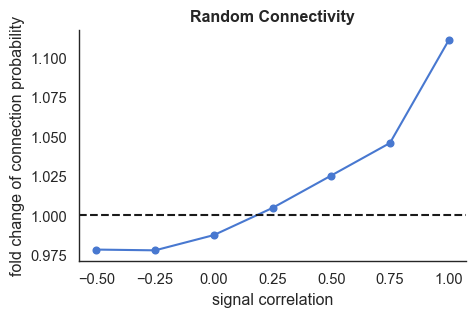

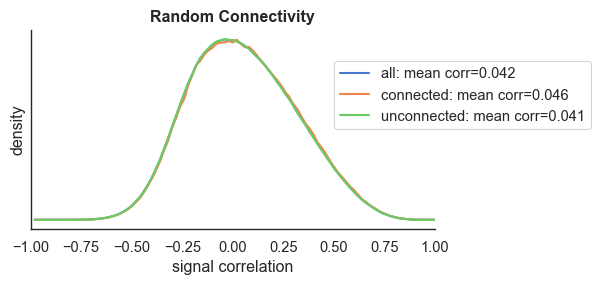

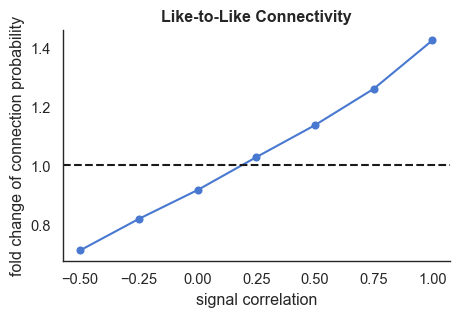

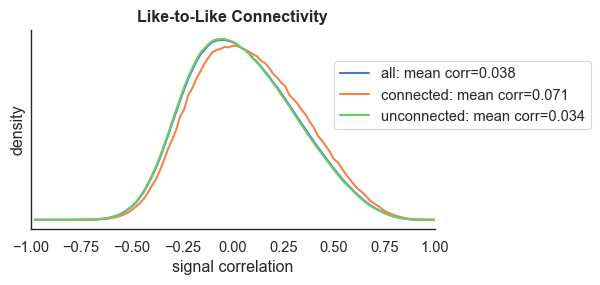

In [63]:
sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')
#%config InlineBackend.figure_format = 'retina'

rmin=1.0/1000

nt=numtrials

dBins=0.02
CorrBins=np.arange(-1,1+dBins,dBins)


# Counts from rates with burn-in
ECounts = winsize*reRand[:nt,:,int(Tburn/winsize):-int(Tburn/winsize)]

# Average over trials
ECounts = ECounts[:nt,:,:].mean(axis=0)


ECutoffInds=np.where(ECounts.sum(axis=1)>T*rmin)[0]
numGood = len(ECutoffInds)
print(numGood,'of',Ne,'E neurons made the cut.')
CutoffEECorrMatrix=np.corrcoef(ECounts[ECutoffInds])
AllEECorrs = CutoffEECorrMatrix[np.triu_indices_from(CutoffEECorrMatrix,k=1)]

Jee=J[:Ne,:Ne]
JeeCutoff=Jee[ECutoffInds,:][:,ECutoffInds]
ConnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(JeeCutoff,k=1))]
UnconnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(np.logical_not(JeeCutoff),k=1))]

mAllEECorrsRand=AllEECorrs.mean()
mConnectedEECorrsRand=ConnectedEECorrs.mean()
mUnconnectedEECorrsRand=UnconnectedEECorrs.mean()


print('Mean EE corr:',mAllEECorrsRand)
print('Std EE corr:',AllEECorrs.std())
print('Mean connected EE corr:',mConnectedEECorrsRand)
print('Mean unconnected EE corr:',mUnconnectedEECorrsRand)


StimCorrBins = np.array([-1,-.5,-.25,0.0,.25,.5,.75,1.0])
ConnProbAtStimCorrRand=np.zeros(len(StimCorrBins)-1)
for i in range(1,len(StimCorrBins)):
    I1,I2=np.where(np.logical_and(CutoffEECorrMatrix>StimCorrBins[i-1],CutoffEECorrMatrix<=StimCorrBins[i]))
    I11=I1[I1>I2]
    I22=I2[I1>I2]
    ConnProbAtStimCorrRand[i-1]=(JeeCutoff[I11,I22]!=0).mean()

plt.figure(figsize=(5,3))
plt.plot(StimCorrBins[1:],ConnProbAtStimCorrRand/p0,'-o')
plt.axhline(y = 1, color = 'k', linestyle = '--')
plt.title('Random Connectivity', weight='bold')
plt.xlabel('signal correlation')
plt.ylabel('fold change of connection probability')
sns.despine()


hAllEERand,_=np.histogram(AllEECorrs,CorrBins,density=True)
hConnEERand,_=np.histogram(ConnectedEECorrs,CorrBins,density=True)
hUnconnEERand,_=np.histogram(UnconnectedEECorrs,CorrBins,density=True)

plt.figure(figsize=(6,3))
plt.plot(CorrBins[1:],hAllEERand, label="all: mean corr={:.3f}".format(mAllEECorrsRand))
plt.plot(CorrBins[1:],hConnEERand, label="connected: mean corr={:.3f}".format(mConnectedEECorrsRand))
plt.plot(CorrBins[1:],hUnconnEERand, label="unconnected: mean corr={:.3f}".format(mUnconnectedEECorrsRand))
plt.ylabel('density')
plt.xlabel('signal correlation')
plt.legend(loc=(.75,.5))
plt.xlim([-1,1])
plt.title('Random Connectivity', weight='bold')
plt.yticks([])
sns.despine()
plt.tight_layout()

##################



# Counts from rates with burn-in
ECounts = winsize*reLikeLike[:nt,:,int(Tburn/winsize):-int(Tburn/winsize)]

# Average over trials
ECounts = ECounts[:nt,:,:].mean(axis=0)


ECutoffInds=np.where(ECounts.sum(axis=1)>T*rmin)[0]
numGood = len(ECutoffInds)
print(numGood,'of',Ne,'E neurons made the cut.')
CutoffEECorrMatrix=np.corrcoef(ECounts[ECutoffInds])
AllEECorrs = CutoffEECorrMatrix[np.triu_indices_from(CutoffEECorrMatrix,k=1)]

Jee=JLikeLike[:Ne,:Ne]
JeeCutoff=Jee[ECutoffInds,:][:,ECutoffInds]
ConnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(JeeCutoff,k=1))]
UnconnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(np.logical_not(JeeCutoff),k=1))]


StimCorrBins = np.array([-1,-.5,-.25,0.0,.25,.5,.75,1.0])
ConnProbAtStimCorrLikeLike=np.zeros(len(StimCorrBins)-1)
for i in range(1,len(StimCorrBins)):
    I1,I2=np.where(np.logical_and(CutoffEECorrMatrix>StimCorrBins[i-1],CutoffEECorrMatrix<=StimCorrBins[i]))
    I11=I1[I1>I2]
    I22=I2[I1>I2]
    ConnProbAtStimCorrLikeLike[i-1]=(JeeCutoff[I11,I22]!=0).mean()

plt.figure(figsize=(5,3))
plt.plot(StimCorrBins[1:],ConnProbAtStimCorrLikeLike/p0,'-o')
plt.axhline(y = 1, color = 'k', linestyle = '--')
plt.title('Like-to-Like Connectivity', weight='bold')
plt.xlabel('signal correlation')
plt.ylabel('fold change of connection probability')
sns.despine()


print('Mean EE corr:',AllEECorrs.mean())
print('Std EE corr:',AllEECorrs.std())
print('Mean connected EE corr:',ConnectedEECorrs.mean())
print('Mean unconnected EE corr:',UnconnectedEECorrs.mean())

hAllEELikeLike,_=np.histogram(AllEECorrs,CorrBins,density=True)
hConnEELikeLike,_=np.histogram(ConnectedEECorrs,CorrBins,density=True)
hUnconnEELikeLike,_=np.histogram(UnconnectedEECorrs,CorrBins,density=True)

mAllEECorrsLikeLike=AllEECorrs.mean()
mConnectedEECorrsLikeLike=ConnectedEECorrs.mean()
mUnconnectedEECorrsLikeLike=UnconnectedEECorrs.mean()


plt.figure(figsize=(6,3))
plt.plot(CorrBins[1:],hAllEELikeLike, label="all: mean corr={:.3f}".format(mAllEECorrsLikeLike))
plt.plot(CorrBins[1:],hConnEELikeLike, label="connected: mean corr={:.3f}".format(mConnectedEECorrsLikeLike))
plt.plot(CorrBins[1:],hUnconnEELikeLike, label="unconnected: mean corr={:.3f}".format(mUnconnectedEECorrsLikeLike))
plt.ylabel('density')
plt.xlabel('signal correlation')
plt.legend(loc=(.75,.5))
plt.xlim([-1,1])
plt.title('Like-to-Like Connectivity', weight='bold')
plt.yticks([])
sns.despine()
plt.tight_layout()





In [64]:
mAllEECorrs=AllEECorrs.mean()
mConnectedEECorrs=ConnectedEECorrs.mean()
mUnconnectedEECorrs=UnconnectedEECorrs.mean()

import pickle
filename='./Data/RandAndLikeLikeHists.npy'


objects = dict()

objects['hAllEERand']=hAllEERand
objects['hConnEERand']=hConnEERand
objects['hUnconnEERand']=hUnconnEERand
objects['hAllEELikeLike']=hAllEELikeLike
objects['hConnEELikeLike']=hConnEELikeLike
objects['hUnconnEELikeLike']=hUnconnEELikeLike

objects['CorrBins']=CorrBins
objects['mAllEECorrsRand']=mAllEECorrsRand
objects['mConnectedEECorrsRand']=mConnectedEECorrsRand
objects['mUnconnectedEECorrsRand']=mUnconnectedEECorrsRand

objects['mAllEECorrsLikeLike']=mAllEECorrsLikeLike
objects['mConnectedEECorrsLikeLike']=mConnectedEECorrsLikeLike
objects['mUnconnectedEECorrsLikeLike']=mUnconnectedEECorrsLikeLike

objects['ConnProbAtStimCorrRand']=ConnProbAtStimCorrRand
objects['ConnProbAtStimCorrLikeLike']=ConnProbAtStimCorrLikeLike
objects['StimCorrBins']=StimCorrBins


with open(filename, 'wb') as f:
    pickle.dump(objects, f)



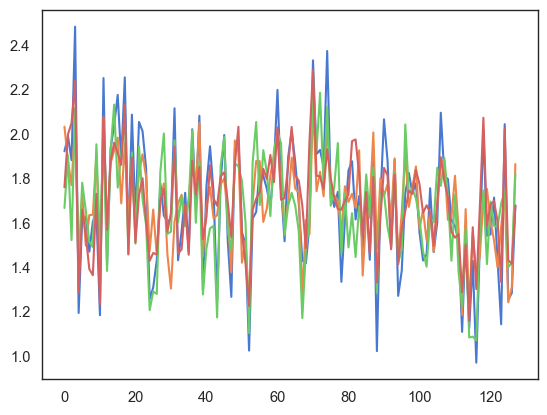

In [5]:
# # Get stimulus weights
# Jx=sigmastim*(0.2*np.random.randn(N,StimDim)+.2)
# Jx[Ne:,:]=0

# # Get random recurrent connectivity matrix
# J=GetBlockErdosRenyi(Ns,Jm,P,Ns)

# # Create re-wired Like-to-Like connectivity matrix
# Pe1=Jx[:Ne,:]@Jx[:Ne,:].T
# Pe1=Pe1-Pe1.min()
# Pe1=Pe1-Pe1*np.eye(Ne)
# Pe1 = Pe1*(alpha*p0/Pe1.mean())
# Pe1[Pe1<0]=0
# MaskEE=np.random.binomial(1,1.0-alpha,size=(Ne,Ne))
# JLikeLike=J.copy()
# JLikeLike[:Ne,:Ne]=MaskEE*JLikeLike[:Ne,:Ne]+Jm[0,0]*np.random.binomial(1,Pe1,size=(Ne,Ne))

# # External input on top of baseline
# X=np.zeros((StimDim,Nt))
# for j in range(StimDim):
#   X[j,:]=MakeSmoothGaussianProcess(taustim,Nt,dt)



# Compute input correlations
Xcoarse = X.reshape((StimDim,-1,int(winsize/dt))).mean(axis=2)
IEXcoarse=Jx[:Ne,:]@Xcoarse


plt.plot(IEXcoarse[:4,:].T+X0[0])

In [7]:
print(T)

32000
